<a href="https://colab.research.google.com/github/Dushyanttara/colab_research/blob/master/Simpl_Assignment(Dushyant_Tara).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Digicard by ABC Payments Bank

## Load & Install Libraries

In [0]:
!pip install pandas-profiling==2.8.0
#!nvidia-smi
!apt-get install default-jre
!java -version
!pip install h2o
!pip install catboost
!pip install shap
!pip install plotly
!pip install lime
!pip install scikit-optimize
!pip install skater

In [3]:
#Importing libraries
import pandas as pd
import numpy as np
import pandas_profiling
import h2o
from h2o.automl import H2OAutoML
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline 
from catboost import *
import xgboost as xgb
from sklearn import tree
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, recall_score, log_loss,roc_auc_score,make_scorer
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, VerboseCallback, DeltaXStopper
from skopt.space import Real, Categorical, Integer
import shap
import pprint
from time import time
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Problem 1) Classify the user as approve or reject.

### Data Preprocessing

In [4]:
!wget https://raw.githubusercontent.com/Dushyanttara/datasets/master/payments.csv

--2020-05-12 16:44:58--  https://raw.githubusercontent.com/Dushyanttara/datasets/master/payments.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10044687 (9.6M) [text/plain]
Saving to: ‘payments.csv’

payments.csv        100%[===================>]   9.58M  10.5MB/s    in 0.9s    

2020-05-12 16:44:59 (10.5 MB/s) - ‘payments.csv’ saved [10044687/10044687]



In [0]:
#Loading data and creating Data dict

dataset = pd.read_csv('payments.csv')

In [6]:
report = dataset.profile_report(sort='None', html={'style':{'full_width': True}}, progress_bar=False)
report

In [0]:
#saving report to file
profile_report = dataset.profile_report(html={'style': {'full_width': True}})
profile_report.to_file("simpl_variables.html")

 Based on basic profiling we realize a few important things:

-- We need to change **DOB** to age of the customer 

-- We need to remove **Email** as that contains personal information of the customer. At the same time we observe that some email_id(s) have multiple users associated to them.This might give us some idea about people belonging to same family, we will ignore this for now but later we can create a new categorical feature(multiple, single)

-- **Inquiry purpose code** has some missing values which we need to take care of. Apart from this we need to convert **IPC** to a categorical variable.

--**Capital gain** and **capital loss** have more than 90% zeros which means either we need to change it to a categorical feature(zero, not_zero) or remove this feature. We will create a combined feature from these two (CG - CL) and convert it to a categorical feature.

--We can remove **user_id** while creating prediction model as it's an identifier column

--For now we will assume that we can take **gender** to predict the approval rate(usually gender bias should be removed before creating the model,for that we can remove this column and create one model without gender as a feature)

--Majority of the **workclass** is in private sector

--We will consider **educational number** as a continous variable, even though it is an ordinal variable(as given in the assignment directions)and remove **education level** from the analysis as both are highly correlated, as expected.

-- **Asset Class cd** has almost 79% missing values, we need to combine this with -1, 01 and name it as **Default** class.

--**Account Type** needs to be converted to a categorical feature and it is highly correlated with **portfolio type** so we will keep just account type because it has 0 missing values.

--We will try remove the **addresses** column for now but for later we can change them to postcode and assign them a cluster id based on their proximity.


Let's create some functions that will take care of the preprocessing for us.

In [0]:
#utility funcs
def to_age(df,x):
  from dateutil.relativedelta import relativedelta
  df['age'] = df[x].apply(lambda x: abs(relativedelta(pd.to_datetime("now"), pd.to_datetime(x)).years))
  return df

def to_profit(x):
  if x > 0:
    return 'profit'
  elif x == 0:
    return 'neutral'
  else:
    return 'loss'

def remove_cols(dataset,remove_list):
  dataset = dataset.drop(remove_list, axis = 1)
  return dataset


def credit_preprocessing(dataset, type_change_dict, fill_na_dict, remove_list):
  data1 = to_age(dataset,'date_of_birth')
  data1['g_l'] = data1['capital_gain'] - data1['capital_loss']
  data1['g_l'] = data1['g_l'].apply(lambda x : to_profit(x))
  data1 = data1[(data1['asset_class_cd'] != '-1') & (data1['asset_class_cd'] != '01')]#as there's only one each value with -1 & 01
  data1 = data1.astype(type_change_dict)
  data1['asset_class_cd'] = data1['asset_class_cd'].cat.add_categories(['Default'])                
  data1.fillna(fill_na_dict,inplace = True)
  data1 = remove_cols(data1, remove_list)
  data1 = data1[[c for c in data1 if c not in ['approved']]+ ['approved']]
  num_cols = data1.select_dtypes(include = 'number').columns#identifying numerical columns
  data1['approved']= data1['approved'].astype('float64')
  x_train, x_test, y_train, y_test = train_test_split(data1.drop('approved', axis =1 ), data1[['approved']], test_size = 0.1, random_state = 1)
  scaler = StandardScaler()
  x_train[num_cols] = scaler.fit_transform(x_train[num_cols])#standardising numerical columns
  x_test[num_cols] = scaler.transform(x_test[num_cols])
  return data1, x_train, x_test, y_train, y_test


creating required dicts and lists.

In [0]:
remove_list = ['user_id','date_of_birth', 'capital_gain', 'capital_loss', 'address','education_level','email','portfolio_type']

fill_na_dict = {'asset_class_cd': 'Default', 
                'inquiry_purpose_code': dataset['inquiry_purpose_code'].mode()[0],
                'asset_code': dataset['asset_code'].mode()[0]}#changing nulls and NANs with required data

type_change_dict = {
 'gender':'category',
 'workclass':'category',
 'marital_status':'category',
 'occupation':'category',
 'relationship': 'category',
 'inquiry_purpose_code': 'category',
 'institute_type':'category',
 'account_type':'category',
 'asset_class_cd': 'category',
 'g_l':'category',
 'asset_code':'category',
 'portfolio_type':'category',
 'education_num': 'int64',
 'approved':'bool'
 }

In [0]:
final_df, x_train, x_test, y_train, y_test = credit_preprocessing(dataset, type_change_dict, fill_na_dict, remove_list)

Let's profile final_df now

In [12]:
report = final_df.profile_report(sort='None', html={'style':{'full_width': True}}, progress_bar=False)
report.to_file("simpl_variables1.html")

In [0]:
report.to_file("simpl_variables1.html")

In [0]:
#saving report to file
profile_report = final_df.profile_report(html={'style': {'full_width': True}})
profile_report.to_file("simpl_variables.html")

###Auto-ML

In [13]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.7" 2020-04-14; OpenJDK Runtime Environment (build 11.0.7+10-post-Ubuntu-2ubuntu218.04); OpenJDK 64-Bit Server VM (build 11.0.7+10-post-Ubuntu-2ubuntu218.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpzf28ghd0
  JVM stdout: /tmp/tmpzf28ghd0/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpzf28ghd0/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ------------------------------------------------------------------
H2O_cluster_uptime:         03 secs
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.30.0.2
H2O_cluster_version_age:    13 days
H2O_cluster_name:           H2O_from_python_unknownUser_xwu4sz
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    3.180 Gb
H2O_cluster_total_cores:    2
H2O_cluster_allowed_cores:  2
H2O_cluster_status:         accepting new members, healthy
H2O_connection_url:         http://127.0.0.1:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
H2O_API_Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, TargetEncoder, Core V4
Python_version:             3.6.9 final
--------------------------  ------------------------------------------------------------------

In [0]:
final_df['approved']= final_df['approved'].astype('bool')

In [15]:
final_df_h2o = h2o.H2OFrame(final_df)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [16]:
final_df_h2o.types

{'account_type': 'int',
 'age': 'int',
 'approved': 'enum',
 'asset_class_cd': 'enum',
 'asset_code': 'int',
 'education_num': 'int',
 'g_l': 'enum',
 'gender': 'enum',
 'hours_per_week': 'int',
 'inquiry_purpose_code': 'int',
 'institute_type': 'enum',
 'marital_status': 'enum',
 'occupation': 'enum',
 'relationship': 'enum',
 'workclass': 'enum'}

In [0]:
h2o_train, h2o_test, h2o_valid = final_df_h2o.split_frame(ratios = [.8,.1])

In [0]:
y = "approved"
x = h2o_train.columns
x.remove(y)

In [0]:
aml = H2OAutoML(max_models= 10 , seed = 10,  verbosity= "info", nfolds = 10)

In [20]:
aml.train(x =x, y = y, training_frame= h2o_train, validation_frame= h2o_valid)

AutoML progress: |
16:49:42.823: Project: AutoML_20200512_164942815
16:49:42.824: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.
16:49:42.824: Setting stopping tolerance adaptively based on the training frame: 0.005263084999327537
16:49:42.825: Build control seed: 10
16:49:42.825: training frame: Frame key: automl_training_py_2_sid_aef9    cols: 15    rows: 36101  chunks: 2    size: 524380  checksum: 1015202013692138901
16:49:42.826: validation frame: Frame key: py_4_sid_aef9    cols: 15    rows: 4512  chunks: 2    size: 77959  checksum: 1015222324282279066
16:49:42.826: leaderboard frame: NULL
16:49:42.827: blending frame: NULL
16:49:42.827: response column: approved
16:49:42.827: fold column: null
16:49:42.827: weights column: null
16:49:42.874: Loading execution steps: [{XGBo

In [0]:
lb = aml.leaderboard

In [22]:
lb.head()

model_id auc logloss aucpr mean_per_class_error rmse mse 
 
 
 StackedEnsemble_AllModels_AutoML_20200512_164942 0.913953 0.329616 0.782135 0.174753 0.320422 0.10267 
 StackedEnsemble_BestOfFamily_AutoML_20200512_164942 0.913648 0.329792 0.781911 0.174626 0.320492 0.102715 
 XGBoost_3_AutoML_20200512_164942 0.912846 0.31575 0.781427 0.1782 0.317435 0.100765 
 GBM_1_AutoML_20200512_164942 0.912597 0.317054 0.779541 0.174758 0.317895 0.101057 
 GBM_2_AutoML_20200512_164942 0.912006 0.317994 0.778533 0.175882 0.318635 0.101528 
 GBM_3_AutoML_20200512_164942 0.911446 0.319113 0.776242 0.172607 0.319244 0.101917 
 GBM_5_AutoML_20200512_164942 0.911417 0.318457 0.777275 0.177947 0.318965 0.101739 
 GBM_4_AutoML_20200512_164942 0.908511 0.324663 0.767045 0.173625 0.321989 0.103677 
 XGBoost_1_AutoML_20200512_164942 0.907578 0.326408 0.767271 0.182744 0.32314 0.10442 
 XGBoost_2_AutoML_20200512_164942 0.90712 0.328847 0.763128 0.180455 0.324445 0.105265

In [23]:
y_pred = aml.leader.predict(h2o_test)

stackedensemble prediction progress: |████████████████████████████████████| 100%


In [24]:
y_pred.head()

predict False True 
 
 
 False 0.959859 0.0401406 
 True 0.723884 0.276116 
 False 0.960246 0.039754 
 False 0.960124 0.0398758 
 False 0.942953 0.0570468 
 False 0.937924 0.0620758 
 False 0.857672 0.142328 
 False 0.927093 0.0729066 
 False 0.958579 0.0414205 
 False 0.959722 0.0402783

In [25]:
aml.leader.model_performance(h2o_test)


ModelMetricsBinomialGLM: stackedensemble
** Reported on test data. **

MSE: 0.09836648827689973
RMSE: 0.3136343225428297
LogLoss: 0.31681076429723853
Null degrees of freedom: 4606
Residual degrees of freedom: 4599
Null deviance: 5074.383504511117
Residual deviance: 2919.0943822347554
AIC: 2935.0943822347554
AUC: 0.9176027811241239
AUCPR: 0.785220009633104
Gini: 0.8352055622482477

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2885502668353548: 


False    True   Error             Rate
0  False  3057.0   447.0  0.1276   (447.0/3504.0)
1   True   243.0   860.0  0.2203   (243.0/1103.0)
2  Total  3300.0  1307.0  0.1498   (690.0/4607.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold        value    idx
0                        max f1   0.288550     0.713693  246.0
1                        max f2   0.121073     0.801661  325.0
2                  max f0point5   0.644811     0.732645  125.0
3                  max accuracy   0.495961     0.861081  173.0
4                 max precision   0.952246     1.000000    0.0
5                    max recall   0.040093     1.000000  398.0
6               max specificity   0.952246     1.000000    0.0
7              max absolute_mcc   0.288550     0.617312  246.0
8    max min_per_class_accuracy   0.213139     0.834760  279.0
9   max mean_per_class_accuracy   0.197978     0.838547  287.0
10                      max tns   0.952246  3504.000000    0.0
11                      max fns   0.952246  1101.000000    0.0
12                      max fps   0.039703  3504.000000  399.0
13                      max tps   0.040093  1103.000000  398.0
14                      max tnr   0.952246     1.000000    0.0
15                      max fnr   0.952246     0.998187    0.0
16                      max fpr   0.039703     1.000000  399.0
17                      max tpr   0.040093     1.000000  398.0


Gains/Lift Table: Avg response rate: 23.94 %, avg score: 24.53 %


group  cumulative_data_fraction  lower_threshold      lift  \
0         1                  0.010202         0.941291  4.176791   
1         2                  0.020187         0.933123  3.995191   
2         3                  0.030171         0.924053  3.995191   
3         4                  0.040156         0.911471  3.631992   
4         5                  0.050141         0.899410  3.541192   
5         6                  0.100065         0.809871  3.486712   
6         7                  0.149989         0.688360  2.869274   
7         8                  0.200130         0.523984  2.224005   
8         9                  0.299978         0.250556  1.761516   
9        10                  0.400043         0.121197  1.105355   
10       11                  0.500109         0.069377  0.471135   
11       12                  0.599957         0.051570  0.308719   
12       13                  0.700022         0.044852  0.090603   
13       14                  0.799870         0.041634  0.027240   
14       15                  0.899935         0.040215  0.009060   
15       16                  1.000000         0.039462  0.000000   

    cumulative_lift  response_rate     score  cumulative_response_rate  \
0          4.176791       1.000000  0.946783                  1.000000   
1          4.086967       0.956522  0.936591                  0.978495   
2          4.056595       0.956522  0.927907                  0.971223   
3          3.951018       0.869565  0.916997                  0.945946   
4          3.869408       0.847826  0.905441                  0.926407   
5          3.678475       0.834783  0.860132                  0.880694   
6          3.409132       0.686957  0.750879                  0.816208   
7          3.112207       0.532468  0.609548                  0.745119   
8          2.662628       0.421739  0.375074                  0.637482   
9          2.273099       0.264642  0.181897                  0.544221   
10         1.912550       0.112798  0.091863                  0.457899   
11         1.645631       0.073913  0.058772                  0.393994   
12         1.423347       0.021692  0.047768                  0.340775   
13         1.249070       0.006522  0.042971                  0.299050   
14         1.111192       0.002169  0.040848                  0.266040   
15         1.000000       0.000000  0.039845                  0.239418   

    cumulative_score  capture_rate  cumulative_capture_rate        gain  \
0           0.946783      0.042611                 0.042611  317.679057   
1           0.941742      0.039891                 0.082502  299.519098   
2           0.937163      0.039891                 0.122393  299.519098   
3           0.932149      0.036265                 0.158658  263.199180   
4           0.926831      0.035358                 0.194016  254.119201   
5           0.893554      0.174071                 0.368087  248.671213   
6           0.846064      0.143246                 0.511333  186.927352   
7           0.786807      0.111514                 0.622847  122.400537   
8           0.649761      0.175884                 0.798731   76.151602   
9           0.532732      0.110607                 0.909338   10.535455   
10          0.444520      0.047144                 0.956482  -52.886527   
11          0.380321      0.030825                 0.987307  -69.128070   
12          0.332784      0.009066                 0.996374  -90.939717   
13          0.296607      0.002720                 0.999093  -97.276006   
14          0.268169      0.000907                 1.000000  -99.093972   
15          0.245321      0.000000                 1.000000 -100.000000   

    cumulative_gain  
0        317.679057  
1        308.696712  
2        305.659516  
3        295.101811  
4        286.940772  
5        267.847499  
6        240.913152  
7        211.220729  
8        166.262843  
9        127.309872  
10        91.254950  
11        64.563131  
12        42.334662  
13    

In [26]:
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
model_ids

['StackedEnsemble_AllModels_AutoML_20200512_164942',
 'StackedEnsemble_BestOfFamily_AutoML_20200512_164942',
 'XGBoost_3_AutoML_20200512_164942',
 'GBM_1_AutoML_20200512_164942',
 'GBM_2_AutoML_20200512_164942',
 'GBM_3_AutoML_20200512_164942',
 'GBM_5_AutoML_20200512_164942',
 'GBM_4_AutoML_20200512_164942',
 'XGBoost_1_AutoML_20200512_164942',
 'XGBoost_2_AutoML_20200512_164942',
 'DRF_1_AutoML_20200512_164942',
 'GLM_1_AutoML_20200512_164942']

In [0]:
out = h2o.get_model([mid for mid in model_ids if "XGBoost" in mid][0])

In [28]:
out.convert_H2OXGBoostParams_2_XGBoostParams()

({'alpha': 0.0,
  'booster': 'gbtree',
  'colsample_bylevel': 0.8,
  'colsample_bytree': 0.8,
  'eta': 0.3,
  'gamma': 0.0,
  'gpu_id': 0,
  'grow_policy': 'depthwise',
  'lambda': 1.0,
  'max_bin': 256,
  'max_delta_step': 0.0,
  'max_depth': 5,
  'min_child_weight': 3.0,
  'nround': 57,
  'nthread': 2,
  'objective': 'binary:logistic',
  'seed': 12,
  'silent': True,
  'subsample': 0.8,
  'updater': 'grow_gpu_hist'},
 57)

In [29]:
out.confusion_matrix()


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35291003034665036: 


False     True   Error               Rate
0  False  23720.0   3346.0  0.1236   (3346.0/27066.0)
1   True   1786.0   7249.0  0.1977    (1786.0/9035.0)
2  Total  25506.0  10595.0  0.1422   (5132.0/36101.0)

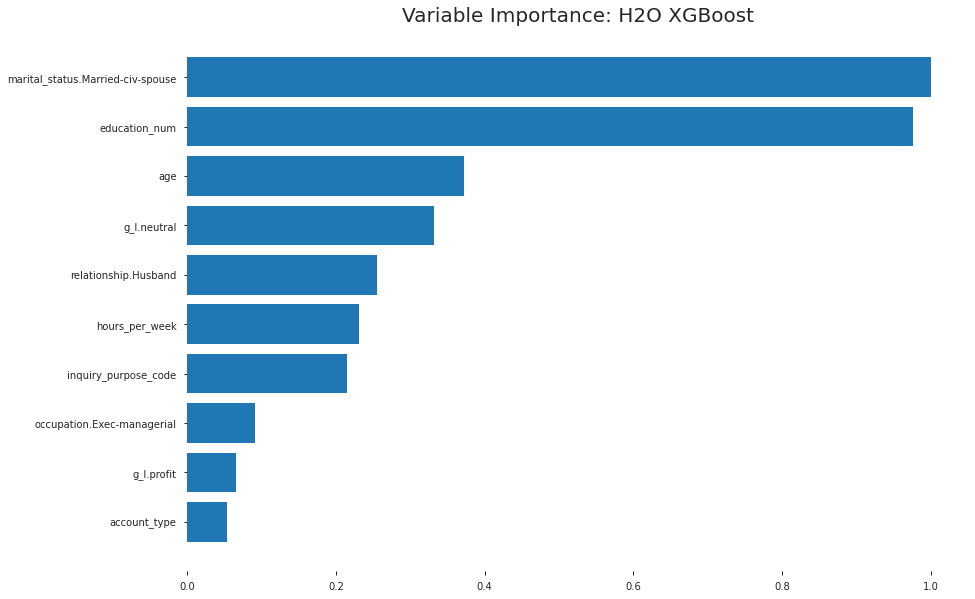

In [30]:
out.varimp_plot()

In [31]:
aml.leader.download_mojo(path = "./")#saving the model as a binary file, which can be deployed in python, java programs for faster execution

'/content/StackedEnsemble_AllModels_AutoML_20200512_164942.zip'

With the help of H2O's AutoML we can see the feature importance and we know that following features are really important:

--Marital status == married civ spouse

--education number

--age of the customer

--gl_neutral might just be coming because almost 90% observations had gl_neutral, we can even remove this feature

--relationship == husband

--hours per week

--inquiry purpose code ( which informs us about the type of loan)

--managerial occupation

--the model might have considered account type as a continuous variable, we will convert it to categorical in our model.

### Baseline Model (Catboost)

As our data has a lot of categorical features, we'll try using catboost to see how it performs.

In [0]:
cat_cols = final_df.select_dtypes(include = 'category')

In [0]:
cat_feat_index = [final_df.columns.get_loc(c) for c in cat_cols if c in final_df]

In [38]:
for col in x_train.columns:
  print(col, x_train[col].nunique())

gender 2
workclass 7
education_num 16
marital_status 7
occupation 14
relationship 6
hours_per_week 96
inquiry_purpose_code 18
institute_type 10
account_type 36
asset_class_cd 7
asset_code 4
age 74
g_l 3


In [0]:
def log_loss(m, X, y):
  return metrics.log_loss(y, m.predict_proba(X)[:,1])

def permutation_importance(model, X, y, metric):
  baseline = metric(model, X, y)
  imp = []
  for col in X.columns:
    save_column = X[col].copy()
    X[col] = np.random.permutation(X[col])
    m = metric(model, X, y)
    X[col] = save_column
    imp.append(m - baseline)
  return np.array(imp)


In [0]:
type_dict_change2 = {'inquiry_purpose_code': 'int64',
                     'asset_code':'int64'}

In [0]:
x_train=x_train.astype(type_dict_change2)
x_test=x_test.astype(type_dict_change2)

In [42]:
iteration = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
loss = []

for i in iteration:
  model = CatBoostClassifier(one_hot_max_size= 10, iterations= i)
  model.fit( x_train, y_train, cat_features = cat_feat_index, verbose = False)
  loss.append((i, log_loss(model, x_test, y_test), log_loss(model, x_train, y_train)))
  print(i)

50
100
150
200
250
300
350
400
450
500


<function matplotlib.pyplot.show>

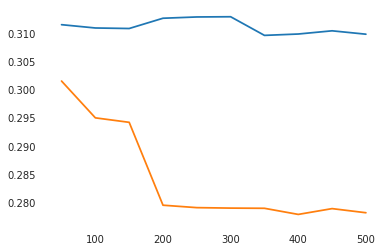

In [43]:
plt.plot([i[0] for i in loss], [i[1] for i in loss])
plt.plot([i[0] for i in loss], [i[2] for i in loss])
plt.show

In [44]:
model = CatBoostClassifier(one_hot_max_size= 10, iterations= 350)
model.fit(x_train, y_train, cat_features = cat_feat_index, verbose = False)

In [45]:
for i in range(0,13):
  print(i, x_train.columns[i],model.get_feature_importance()[i])

0 gender 1.8471275608828002
1 workclass 3.6150915490529942
2 education_num 11.490353623352899
3 marital_status 25.558060718719215
4 occupation 9.450254598059326
5 relationship 3.6275574900214163
6 hours_per_week 8.954598136684574
7 inquiry_purpose_code 7.210520033867938
8 institute_type 2.5148007049902756
9 account_type 4.034468798819688
10 asset_class_cd 1.6556348042422686
11 asset_code 0.46246781060593517
12 age 13.793294712241499


In [0]:
y_pred = model.predict(x_test)

In [0]:
y_pred_prob = model.predict_proba(x_test)

In [48]:
y_pred[:10]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 1.])

In [0]:
cat_preds = (y_pred_prob < 0.5)#we accidentally took false class as positive

In [0]:
cat_preds = cat_preds[:,0]

In [51]:
confusion_matrix(y_test, cat_preds)

array([[3154,  230],
       [ 385,  753]])

In [52]:
f1_score(y_test, y_pred)

0.7100424328147101

In [53]:
recall_score(y_test, y_pred)

0.6616871704745168

In [54]:
print('Test ROC-AUC score:', roc_auc_score(y_test, y_pred_prob[:,1]))

Test ROC-AUC score: 0.916002032722997


### Optimized Catboost (SKOPTS) Bayesian hyperparameter tuning

We will use Bayesian optimization to optimize catboost now

In [0]:
# Reporting util for different optimizers
def report_perf(optimizer, X, y, title, callbacks=None):
    """
    A wrapper for measuring time and performances of different optmizers
    
    optimizer = a sklearn or a skopt optimizer
    X = the training set 
    y = our target
    title = a string label for the experiment
    """
    start = time()
    if callbacks:
        optimizer.fit(X, y, callback=callbacks)
    else:
        optimizer.fit(X, y)
    d=pd.DataFrame(optimizer.cv_results_)
    best_score = optimizer.best_score_
    best_score_std = d.iloc[optimizer.best_index_].std_test_score
    best_params = optimizer.best_params_
    print((title + " took %.2f seconds,  candidates checked: %d, best CV score: %.3f "
           +u"\u00B1"+" %.3f") % (time() - start, 
                                  len(optimizer.cv_results_['params']),
                                  best_score,
                                  best_score_std))    
    print('Best parameters:')
    pprint.pprint(best_params)
    print()
    return best_params

In [0]:
roc_auc = make_scorer(roc_auc_score, greater_is_better=True, needs_threshold=True)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [0]:
clf = CatBoostClassifier(thread_count=2,
                         loss_function='Logloss',
                         od_type = 'Iter',
                         verbose= False,
                    cat_features = cat_feat_index
                        )

In [0]:
search_spaces = {'iterations': Integer(10, 1000),
                 'depth': Integer(1, 8),
                 'learning_rate': Real(0.01, 1.0, 'log-uniform'),
                 'random_strength': Real(1e-9, 10, 'log-uniform'),
                 'bagging_temperature': Real(0.0, 1.0),
                 'border_count': Integer(1, 255),
                 'l2_leaf_reg': Integer(2, 30),
                 'scale_pos_weight':Real(0.01, 1.0, 'uniform')}

In [0]:
# Setting up BayesSearchCV
opt = BayesSearchCV(clf,
                    search_spaces,
                    scoring=roc_auc,
                    cv=skf,
                    n_iter=100,
                    n_jobs=1,  # use just 1 job with CatBoost in order to avoid segmentation fault
                    return_train_score=False,
                    refit=True,
                    optimizer_kwargs={'base_estimator': 'GP'},
                    random_state=42)

In [60]:
best_params = report_perf(opt, x_train, y_train,'CatBoost',callbacks=[VerboseCallback(100),  DeadlineStopper(60*10)])

Iteration No: 1 started. Searching for the next optimal point.
Iteration No: 1 ended. Search finished for the next optimal point.
Time taken: 193.4661
Function value obtained: -0.9148
Current minimum: -0.9148
Iteration No: 2 started. Searching for the next optimal point.
Iteration No: 2 ended. Search finished for the next optimal point.
Time taken: 212.5818
Function value obtained: -0.9104
Current minimum: -0.9148
Iteration No: 3 started. Searching for the next optimal point.
CatBoost took 453.95 seconds,  candidates checked: 2, best CV score: 0.915 ± 0.001
Best parameters:
OrderedDict([('bagging_temperature', 0.41010395885331385),
             ('border_count', 186),
             ('depth', 8),
             ('iterations', 323),
             ('l2_leaf_reg', 21),
             ('learning_rate', 0.0673344419215237),
             ('random_strength', 3.230824361824754e-06),
             ('scale_pos_weight', 0.7421091918485163)])



In [0]:
best_params['iterations']=1000

Make a classifier based on tuned parameters

In [0]:
%%time
tuned_model = CatBoostClassifier(**best_params,task_type = "GPU",od_type='Iter',one_hot_max_size=10)
tuned_model.fit(x_train,y_train, cat_features = cat_feat_index)

In [63]:
%%time
y_pred = tuned_model.predict_proba(x_test)[:, 1]
test_score = roc_auc_score(y_test, y_pred)
print('Validation ROC-AUC score:', test_score)

Validation ROC-AUC score: 0.9160059278232725
CPU times: user 449 ms, sys: 39.3 ms, total: 488 ms
Wall time: 263 ms


In [64]:
y_pred_class = tuned_model.predict(x_test)
confusion_matrix(y_test, y_pred_class)

array([[3210,  174],
       [ 476,  662]])

### Model Interpretability

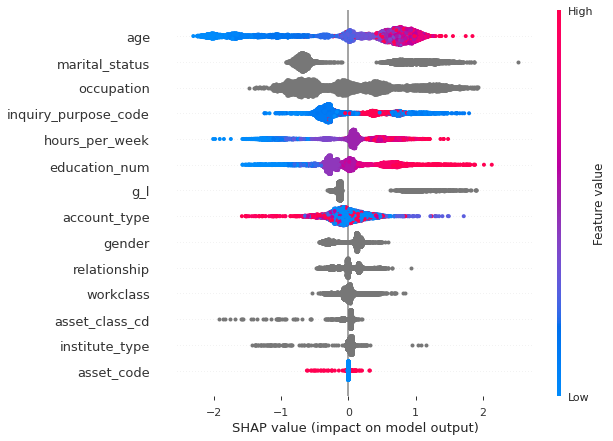

In [65]:
#Shap values
start_time = time()
shap_values = tuned_model.get_feature_importance(Pool(x_test, label = y_test, cat_features= cat_feat_index),
                                           type = "ShapValues")

shap_values = shap_values[:,:-1]
shap.summary_plot(shap_values, x_test)
elapsed = time() - start_time

In [0]:
#parwise interaction of features
fi = model.get_feature_importance(Pool(x_test, label=y_test,cat_features=cat_feat_index), 
                                                                     type="Interaction")

fi_new = []
for k,item in enumerate(fi):  
    first = x_test.dtypes.index[fi[k][0]]
    second = x_test.dtypes.index[fi[k][1]]
    if first != second:
        fi_new.append([first + " -|- " + second, fi[k][2]])

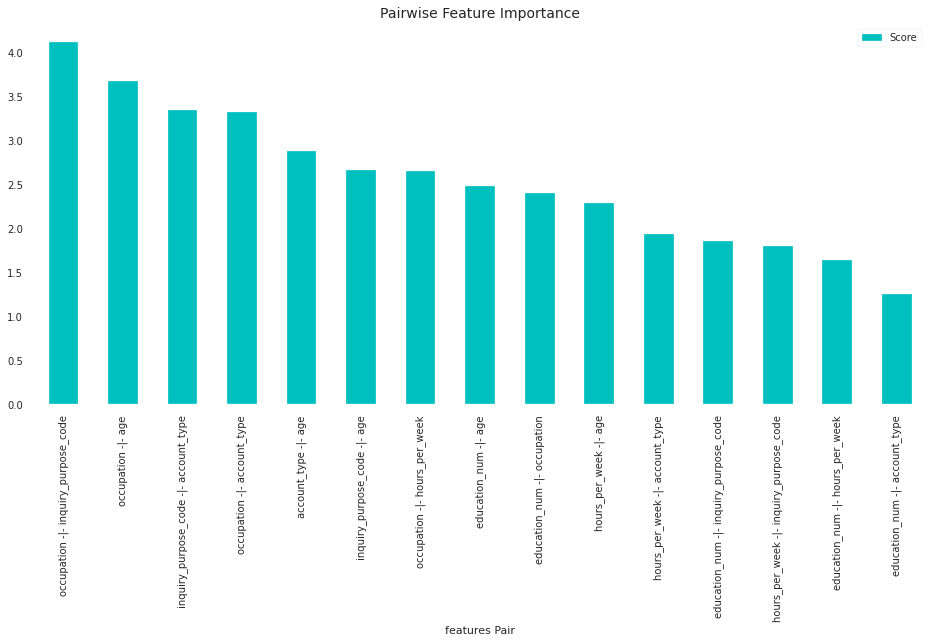

In [67]:
feature_score = pd.DataFrame(fi_new,columns=['Feature-Pair','Score'])
feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')
plt.rcParams["figure.figsize"] = (16,7)
ax = feature_score.plot('Feature-Pair', 'Score', kind='bar', color='c')
ax.set_title("Pairwise Feature Importance", fontsize = 14)
ax.set_xlabel("features Pair")
plt.show()


Based on above information, we can engineer new features based on pairwise interaction of features. 

In [0]:
#Let's try building an XGBoost model and interpret that using some ML interpretablity techniques

In [0]:
final_df = pd.get_dummies(final_df)

In [0]:
x_train,x_test,y_train,y_test = train_test_split(final_df.drop('approved',axis = 1), final_df['approved'], test_size = 0.1,random_state = 0)

In [0]:
#XGboost doesn't require normalization or standardization so we'll skip that

In [72]:
%%time
xgc = xgb.XGBClassifier(n_estimators = 500, max_depth = 5, base_score = 0.5, objective= 'binary:logistic', random_state=10)
xgc.fit(x_train,y_train)


CPU times: user 1min 17s, sys: 101 ms, total: 1min 17s
Wall time: 1min 18s


In [73]:
#Making predictions on test data
predictions = xgc.predict(x_test)
pred_proba = xgc.predict_proba(x_test)
predictions[:10]

array([ True, False, False, False, False,  True, False, False, False,
       False])

In [74]:
confusion_matrix(y_test, predictions)

array([[3102,  281],
       [ 365,  774]])

In [94]:
!pip install skater

In [75]:
print('Areac under ROC :', roc_auc_score(y_test, pred_proba[:,1]))

Areac under ROC : 0.9134970156260827


In [0]:
#Global surrogate
new_target = xgc.predict(x_train)

In [77]:
dt_model = DecisionTreeClassifier(max_depth= 5, random_state = 0)
dt_model.fit(x_train, new_target)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

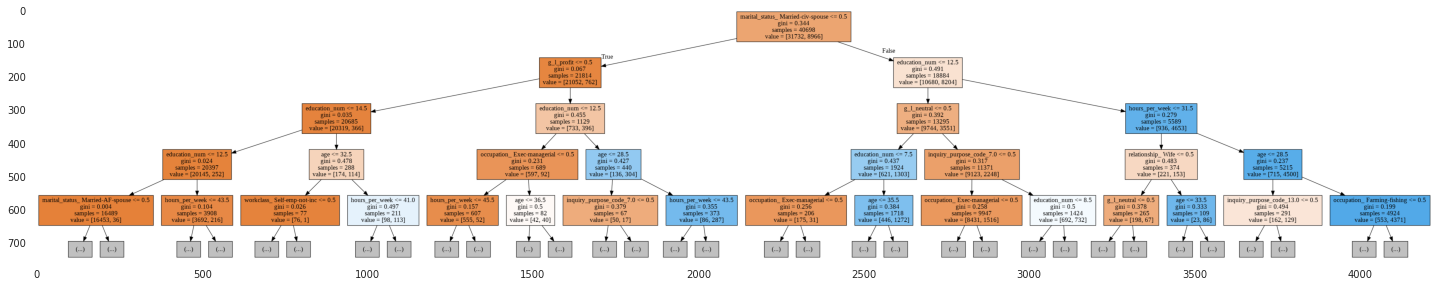

In [78]:
#Let's try to visualize the decision tree
decision_tree = tree.export_graphviz(dt_model, out_file = 'tree.dot', feature_names = x_train.columns, filled = True, max_depth = 4)

# converting the dot image to png format
!dot -Tpng tree.dot -o tree.png

#plotting the decision tree
image = plt.imread('tree.png')
plt.figure(figsize=(25,25))
plt.imshow(image)

## Problem 2) Predict the credit limit to give once approved

We will try to predict the credit limit based on the probability of conversion. 

--for prob(approved) = 0.5 [credit limit = 1000]

--for prob(approved) = 0.1 [credit limit = 8000]

so we will change the range of probability from range [0.5,1] to [1000,8000]

In [0]:
predict_approved = xgc.predict_proba(final_df.drop('approved', axis = 1))

In [0]:
predict_approved = pd.DataFrame(predict_approved[:,1])

In [0]:
predict_approved.columns = ['predictions']

In [104]:
predict_approved.head()

predictions
0     0.004012
1     0.261271
2     0.111005
3     0.000340
4     0.047645

In [0]:
def range_change(dataset,x):
  old_range = 1 - 0.5
  new_range = 8000-1000
  dataset['credit_limit'] = np.where(dataset[x] < 0.5, 0, dataset[x].apply(lambda z: (((z - 0.5)* new_range) / old_range) + 1000))
  return dataset

In [0]:
predict_approved = range_change(predict_approved, 'predictions')

In [108]:
predict_approved.head()

predictions  credit_limit
0     0.004012           0.0
1     0.261271           0.0
2     0.111005           0.0
3     0.000340           0.0
4     0.047645           0.0

In [114]:
predict_approved[predict_approved['credit_limit']>0].max()

predictions        0.998073
credit_limit    7973.021746
dtype: float64

In [115]:
predict_approved[predict_approved['credit_limit']>0].min()

predictions        0.500046
credit_limit    1000.647545
dtype: float64